In [26]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from libs.TrafficGenerator import DatasetConvertor 
from libs.TrafficPredictor.ContextAssisted import PreparingDataset as PreparingDatasetCA
from libs.TrafficPredictor.ContextAssisted import trainModelByDefaultSetting as trainModelCA
from libs.TrafficPredictor.ContextAssisted import evaluateModel as evaluateModelCA
from libs.TrafficPredictor.ContextAssisted import createModel as createModelCA
from libs import encode_float_filename, decode_float_filename

In [27]:
stringFile = encode_float_filename(0.5)
floatFile = decode_float_filename(stringFile)
print(stringFile)
print(floatFile)

5_00e-01.txt
0.5


In [ ]:
dbParams = 0.2
direction = "backward"
mode = "adapt"
alpha = 0.001

rawDatasetFolder = "Dataset"
datasetConverter = DatasetConvertor(rawDatasetFolder)
datasetConverter.processDataset(dbParameter=dbParams, alpha=alpha, mode=mode, direction=direction)
#thumbUnit = datasetConverter.getDataUnit('thumb_fr')
thumbUnit = datasetConverter.getDataUnit('thumb_bk')

========== thumb ============
Backward: Compression rate:0.2032248455322052
========== index ============
Backward: Compression rate:0.18577454908856794
========== middle ============
Backward: Compression rate:0.19320245611000605


In [29]:
lenWindow = 10
trainDataAugment = True
verbose = True

paramsCA = {}
paramsCA['lenSource'] = lenWindow
paramsCA['lenTarget'] = lenWindow
paramsCA['trainRatio'] = 0.5
paramsCA['dataAugment'] = trainDataAugment
paramsCA['smoothFc'] = 1.5
paramsCA['smoothOrder'] = 3
trainData, testData = PreparingDatasetCA(thumbUnit, paramsCA, verbose=verbose)

(sources, _, lastTranmittedContext, _, _, _, _) = trainData
print(sources.shape)
print(lastTranmittedContext.shape)

Train size: 52033, Test size: 52034
(52013, 10, 1)
(52013, 1, 1)


In [30]:
bestWeightsCA, _, _, modleParametersCA = trainModelCA(
paramsCA['lenSource'], paramsCA['lenTarget'], trainData, testData, verbose=verbose)

Size of train loader: 13, Size of test loader: 13
Used device: cuda
Size of model: 837774
TrafficPredictorContextAssisted(
  (dbf2traffic): DeadFeaturesToTrafficLayer(
    (input_layer): Sequential(
      (0): Linear(in_features=66, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.9, inplace=False)
    )
    (hidden_layers): ModuleList(
      (0-2): 3 x Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.9, inplace=False)
      )
    )
    (trans2transmission_layer): Linear(in_features=512, out_features=10, bias=True)
    (sigmoid): Sigmoid()
    (trans2traffic_layer): Linear(in_features=522, out_features=1, bias=True)
    (trans2trafficClass_layer): Linear(in_features=522, out_features=11, bias=True)
  )
  (relu

KeyboardInterrupt: 

Train size: 52033, Test size: 52034
actual_class_shape: (5201, 1), predicted_class_shape: (5201, 11)


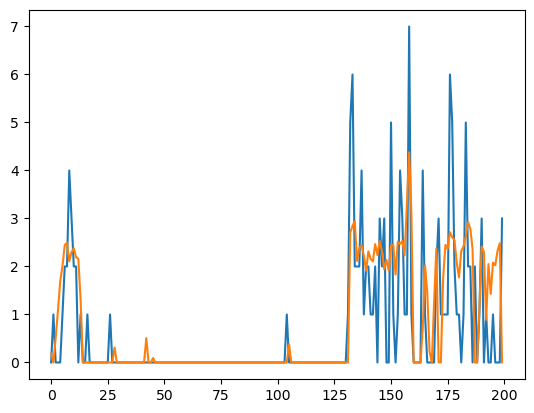

In [ ]:
trafficModelCA, _ = createModelCA(modleParametersCA)
trafficModelCA.load_state_dict(bestWeightsCA)

paramsValid = paramsCA.copy()
paramsValid['dataAugment'] = False
trainData, testData = PreparingDatasetCA(thumbUnit, paramsValid, verbose=verbose)
#(actual_trafficCA_train, predicted_trafficCA_train, actual_class_train, predicted_class_train, _, _, _, _)  = evaluateModelCA(trafficModelCA, trainData)
#(actual_trafficCA_test, predicted_trafficCA_test, actual_class_test, predicted_class_test, _, _, _, _)  = evaluateModelCA(trafficModelCA, trainData)
resultsTrain = evaluateModelCA(trafficModelCA, trainData)
resultsTest = evaluateModelCA(trafficModelCA, testData)

print(f"actual_class_shape: {resultsTrain['classDistribu_actual'].shape}, predicted_class_shape: {resultsTrain['classDistribu_predicted'].shape}")

plt.plot(resultsTest['trafficTarget_actual'][0:200])
plt.plot(resultsTest['trafficTarget_predicted'][0:200])

In [ ]:
dbpString = encode_float_filename(dbParams)
with open(f"Results/TrafficPredictor/evaluate/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "wb") as file:
    pickle.dump(resultsTrain, file)
with open(f"Results/TrafficPredictor/evaluate/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "wb") as file:
    pickle.dump(resultsTest, file)

#modelData = {}
#modelData["trainData"] = trainData
#modelData["testData"] = testData
#with open(f"Results/TrafficPredictor/modelData/{direction}_{lenWindow}_{mode}_{dbpString}.pkl", "wb") as file:
#    pickle.dump(modelData, file)
with open(f"Results/TrafficPredictor/modelParams/{direction}_{lenWindow}_{mode}_{dbpString}.pkl", "wb") as file:
    pickle.dump(modleParametersCA, file)
torch.save(bestWeightsCA, f"Results/TrafficPredictor/model/{direction}_{lenWindow}_{mode}_{dbpString}.pth")